## Ocean Stats

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml, os
import nc_time_axis, cftime
from datetime import datetime
import getpass
import xarray as xr
from mom6_tools.stats import extract_time_series, ocean_stats
from mom6_tools.m6toolbox import cime_xmlquery, genBasinMasks
from mom6_tools.MOM6grid import MOM6grid

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/gmarques/conda-envs/mom6-tools/share/proj failed


Basemap module not found. Some regional plots may not function properly


In [3]:
# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams.update({'font.size': 18})

In [4]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [5]:
caseroot = diag_config_yml['Case']['CASEROOT']
casename = cime_xmlquery(caseroot, 'CASE')
DOUT_S = cime_xmlquery(caseroot, 'DOUT_S')
rundir = cime_xmlquery(caseroot, 'RUNDIR')

if DOUT_S:
  OUTDIR = cime_xmlquery(caseroot, 'DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = cime_xmlquery(caseroot, 'RUNDIR')
    
print('Rundir directory is:', rundir)
print('Casename is:', casename)

Rundir directory is: /glade/derecho/scratch/gmarques/g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079/run
Casename is: g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079


In [6]:
# create an empty class object
class args:
  pass

args.rundir = rundir
args.casename = casename
args.caseroot = caseroot
args.OUTDIR = OUTDIR
args.nw = 6
args.static = casename+diag_config_yml['Fnames']['static']
args.native = casename+diag_config_yml['Fnames']['native']
args.geom =   casename+diag_config_yml['Fnames']['geom']

In [7]:
# read grid info
geom_file = OUTDIR+'/'+args.geom
if os.path.exists(geom_file):
  grd = MOM6grid(OUTDIR+'/'+args.static, geom_file, xrformat=True)
else:
  grd = MOM6grid(OUTDIR+'/'+args.static, xrformat=True)
      
try:
  depth = grd.depth_ocean.values
except:
  depth = grd.deptho.values
    
try:
  area = grd.area_t.where(grd.wet > 0)
except:
  area = grd.areacello.where(grd.wet > 0)

MOM6 grid successfully loaded... 



In [8]:
# remove Nan's, otherwise genBasinMasks won't work
# Get masking for different regions
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon.values, grd.geolat.values, depth, xda=True)

#select a few basins, namely, Global, MedSea,BalticSea,HudsonBay Arctic,
# Pacific, Atlantic, Indian, Southern, LabSea and BaffinBay
basins = basin_code.isel(region=[0,4,5,6,7,8,9,10,11,12,13])

### Integrated T & S

In [9]:
variables = ['thetaoga','soga','opottempmint','somint']
ds = extract_time_series(args.native, variables, area, args)

Reading dataset...
Time elasped:  0:00:45.443396
Releasing workers...



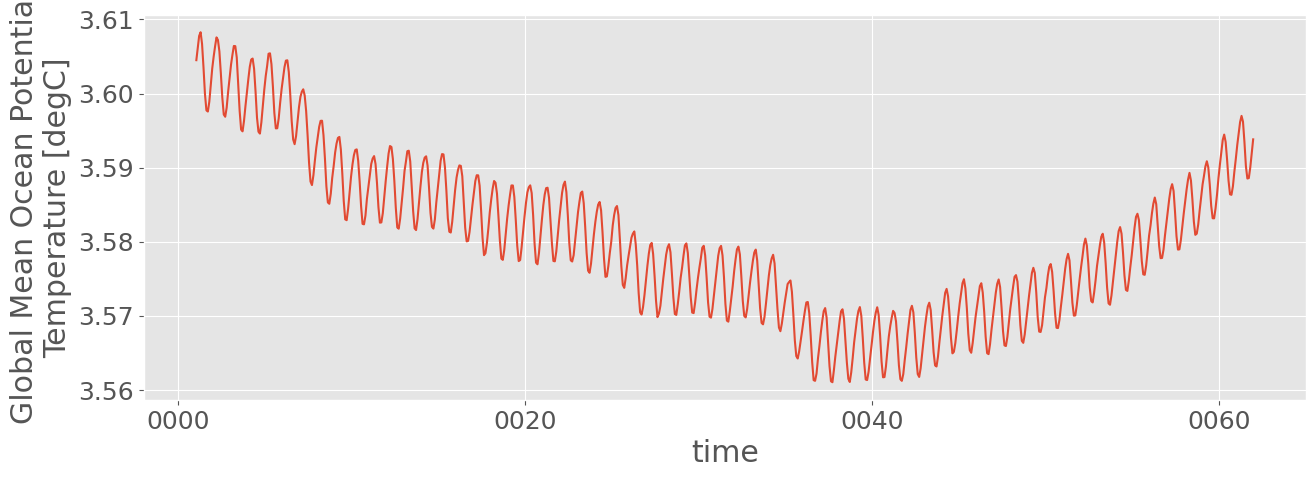

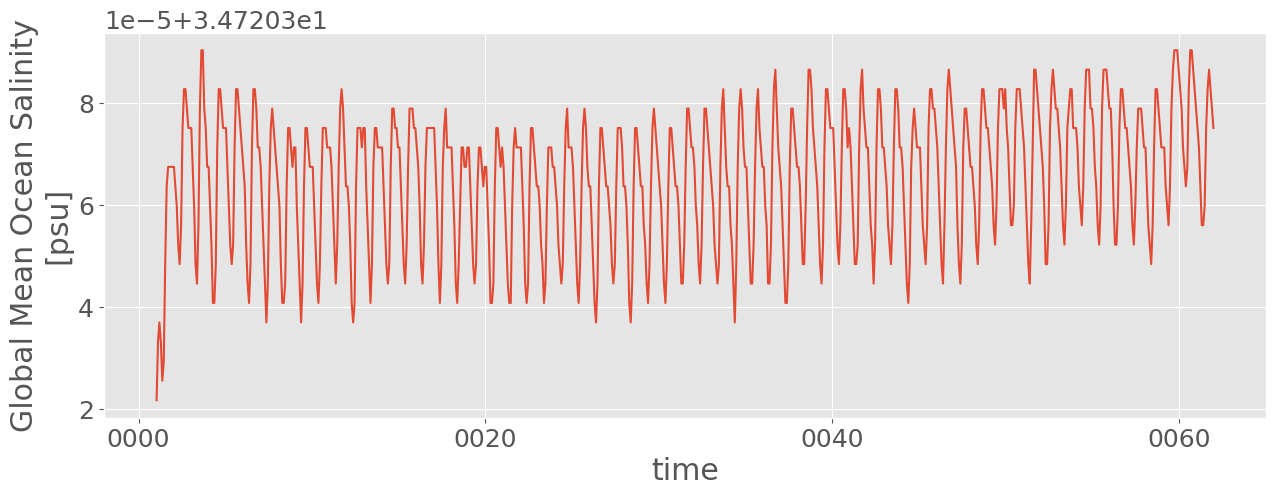

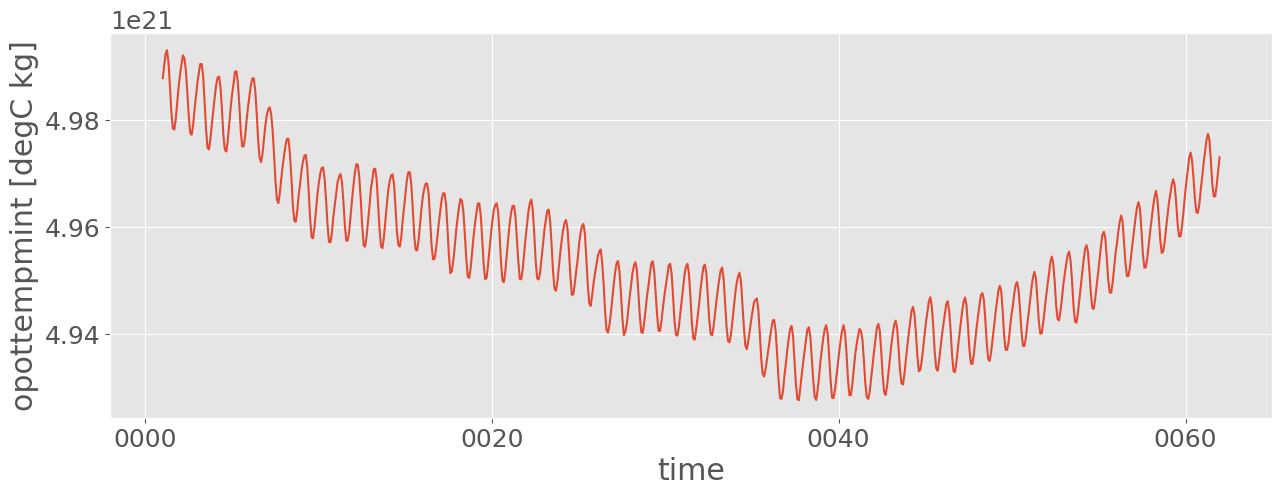

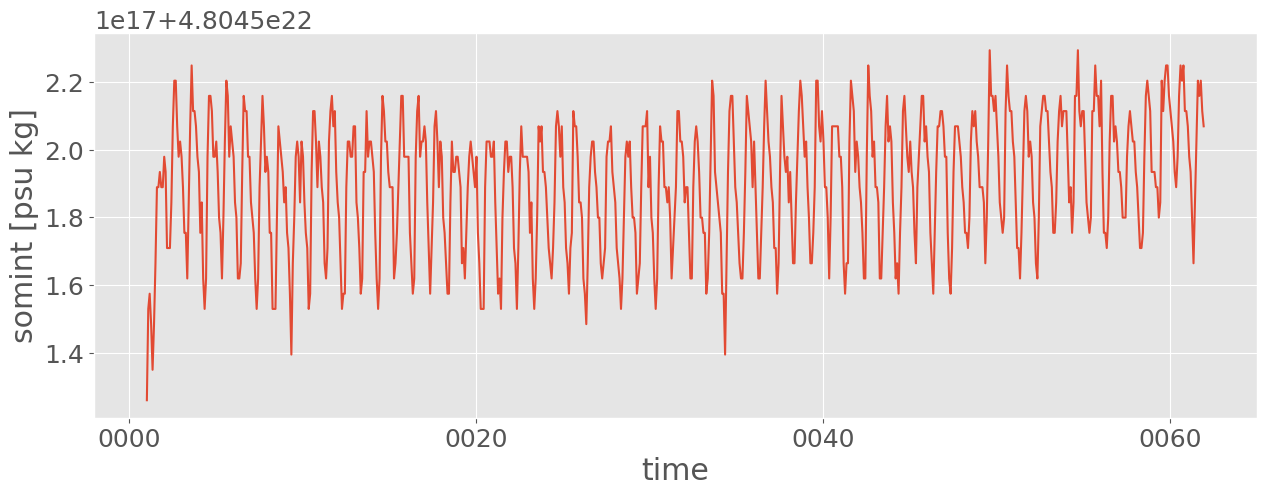

In [10]:
%matplotlib inline

for v in ds.data_vars:
    fig, ax = plt.subplots()
    ds[v].plot(ax=ax)
    ax.set_title('')

In [11]:
stats = ocean_stats(args)

### Truncations

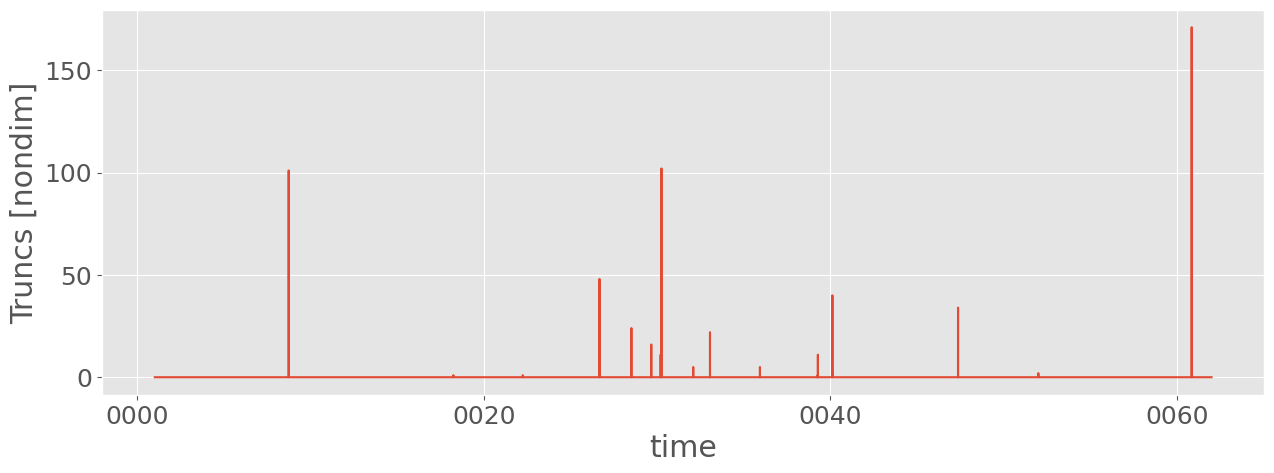

In [12]:
stats.Truncs.plot()

### Maximum finite-volume CFL

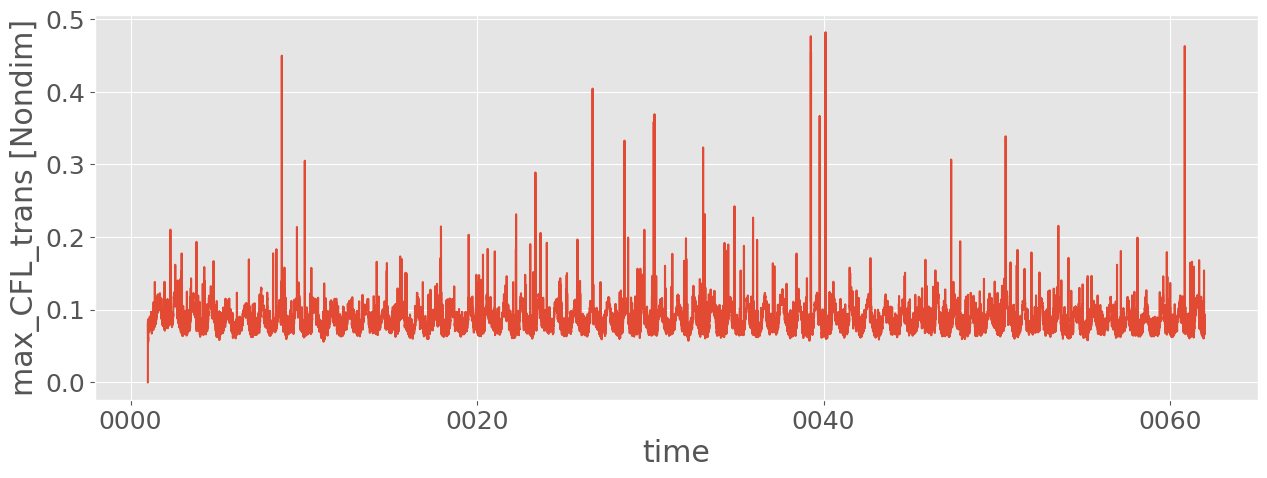

In [13]:
stats.max_CFL_trans.plot();

### Maximum finite-difference CFL

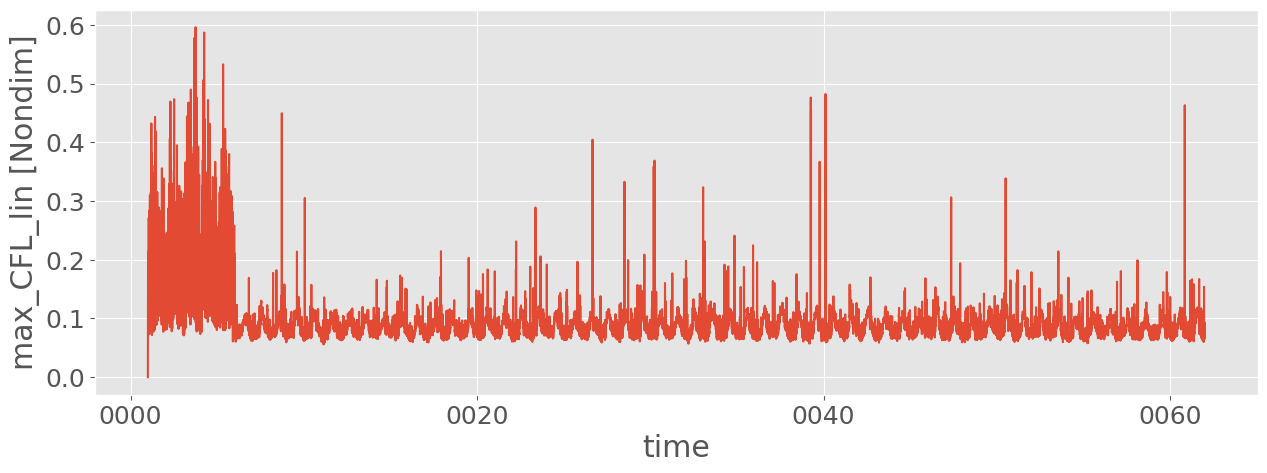

In [14]:
stats.max_CFL_lin.plot();

### Maximum CFL

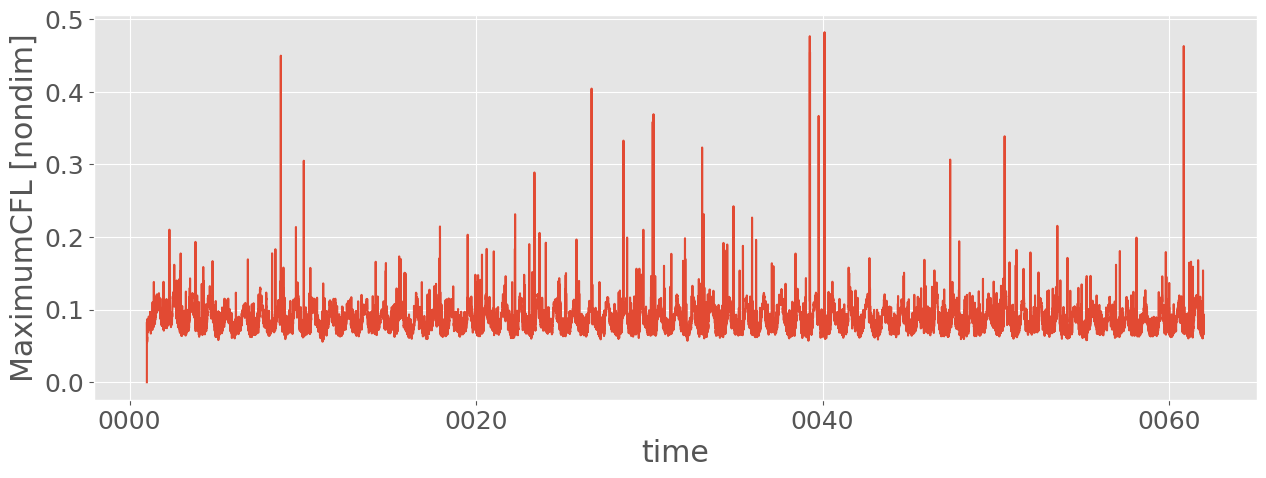

In [15]:
stats.MaximumCFL.plot();

### Energy/Mass

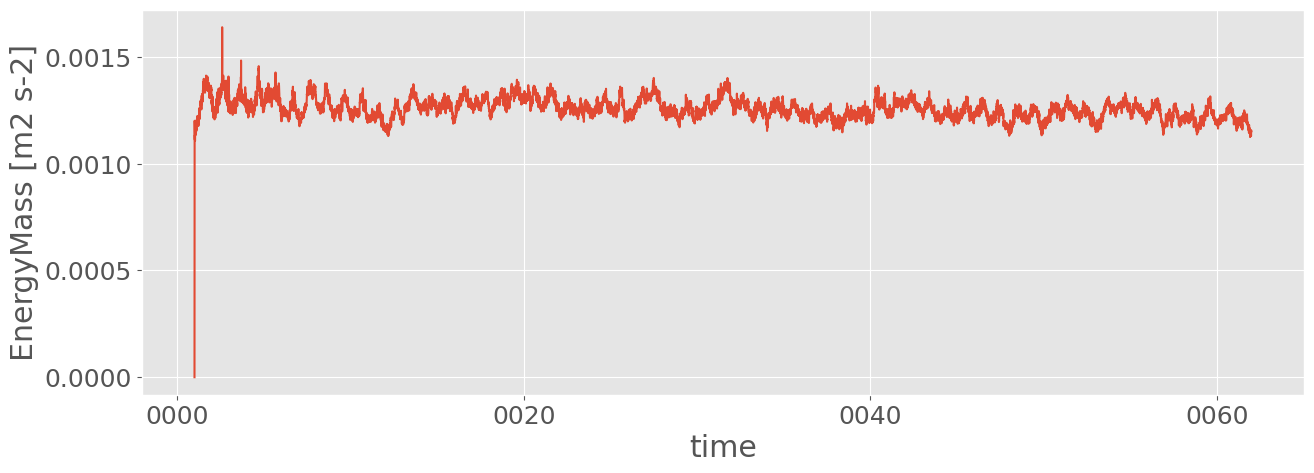

In [16]:
stats.EnergyMass.plot()

### Mean Sea Level

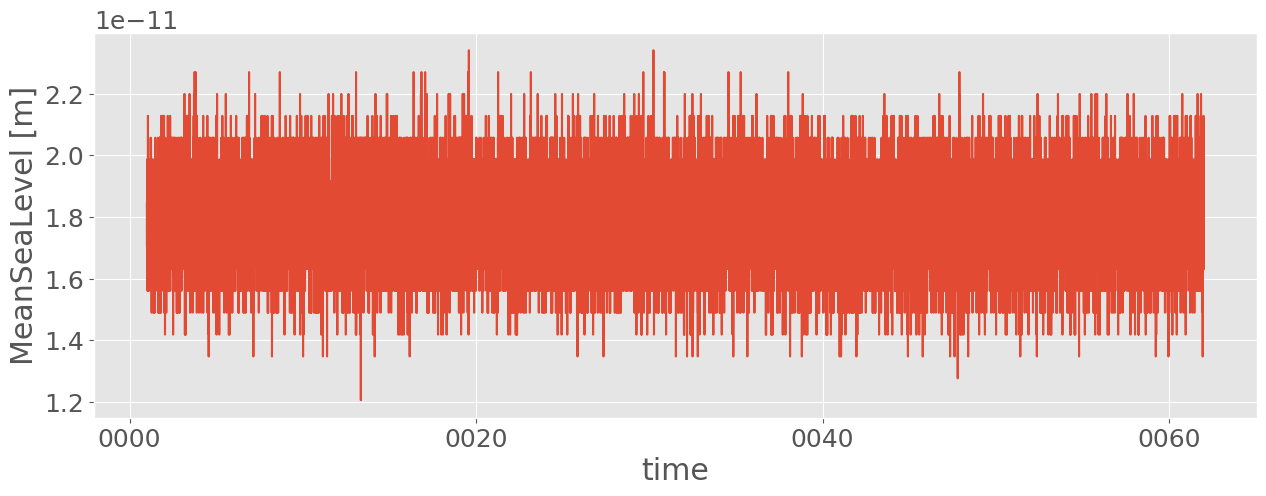

In [17]:
stats.MeanSeaLevel.plot(); 

### Total Mass

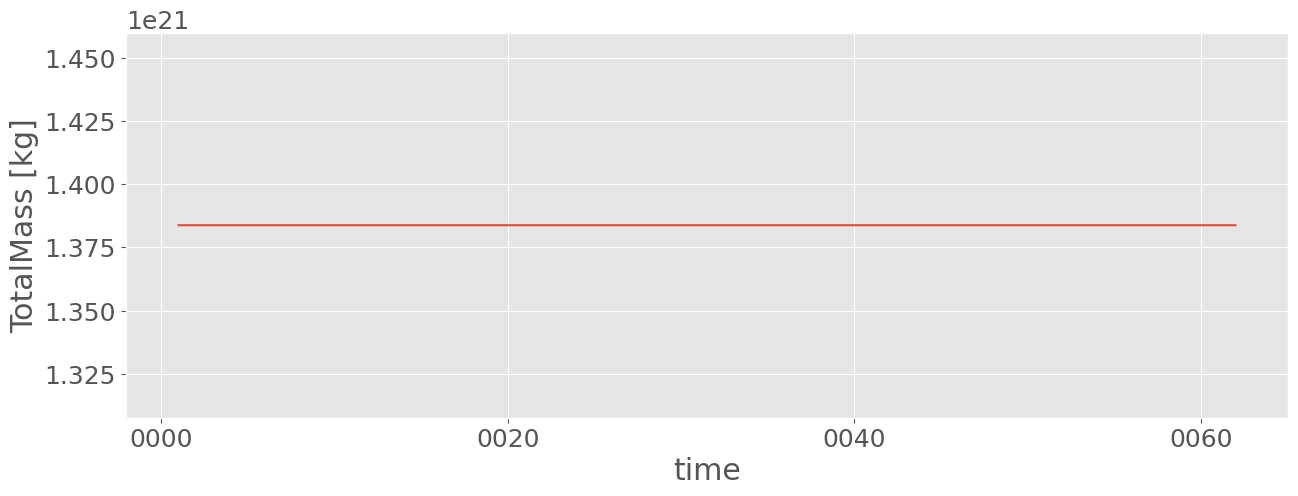

In [18]:
stats.TotalMass.plot(); 

### Mean Salinity

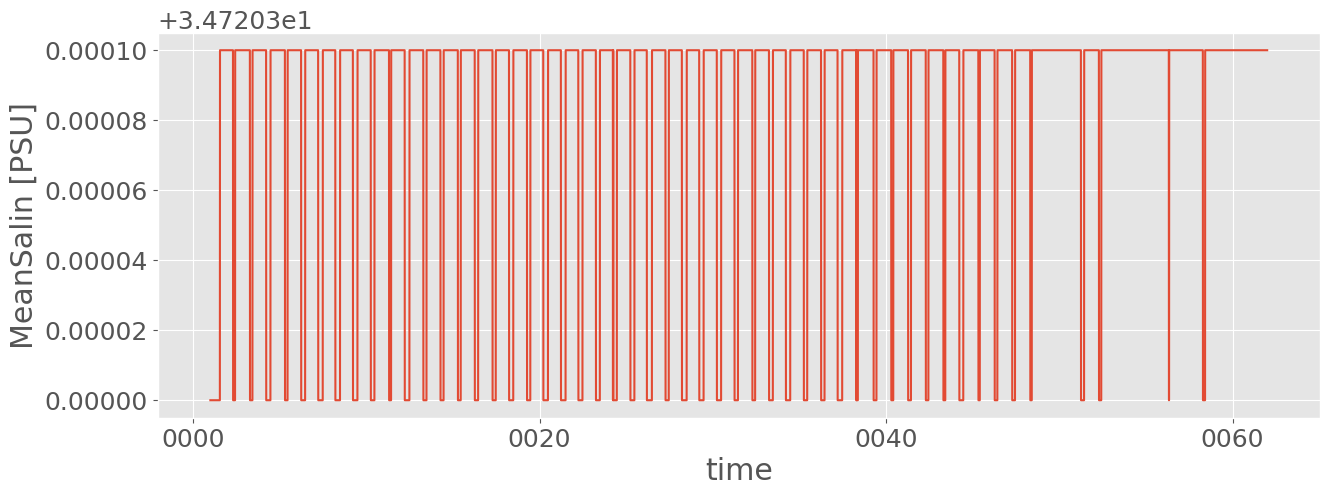

In [19]:
stats.MeanSalin.plot(); 

### Mean Temperature

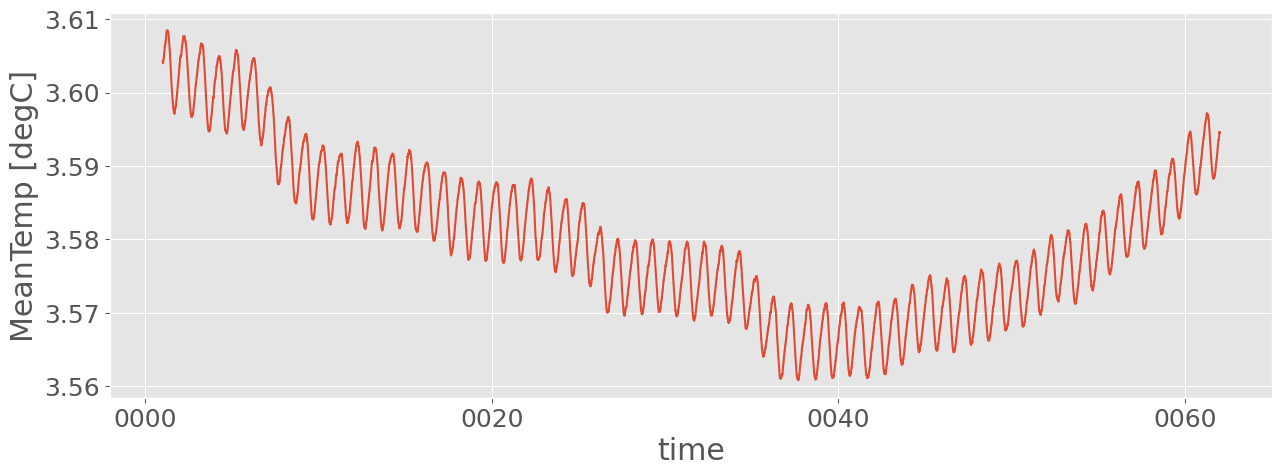

In [20]:
stats.MeanTemp.plot(); 

### Total Energy

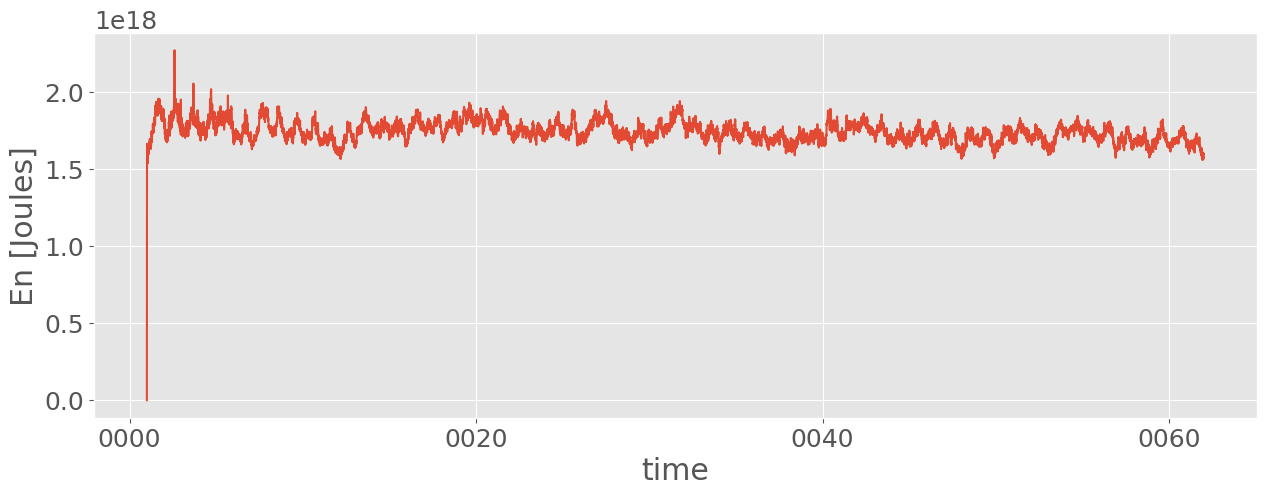

In [21]:
stats.En.plot(); 

### Available Potential Energy

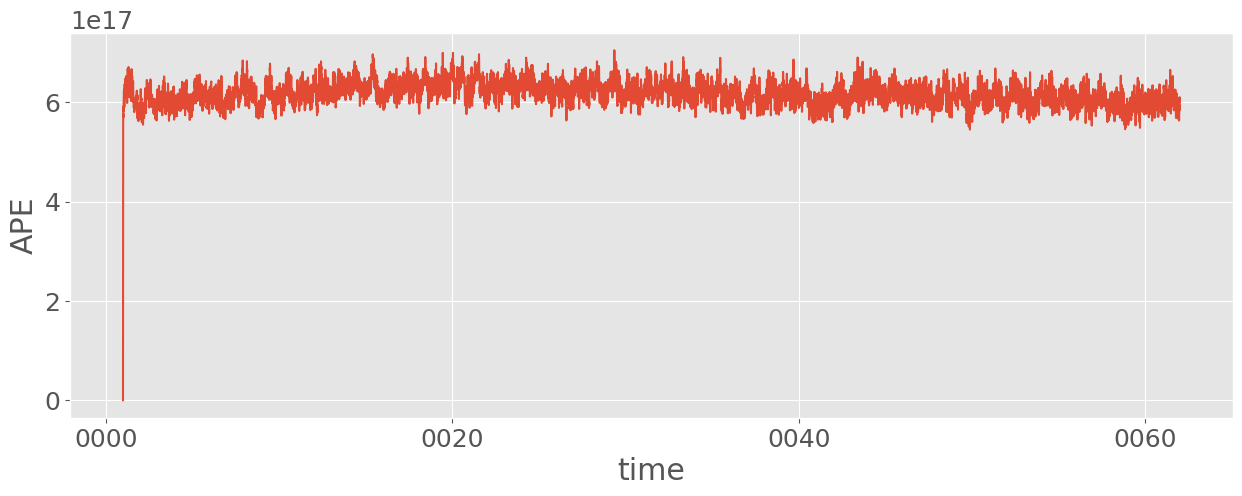

In [22]:
stats.APE.sum(axis=1,keep_attrs=True).plot(); 

### Total Salt

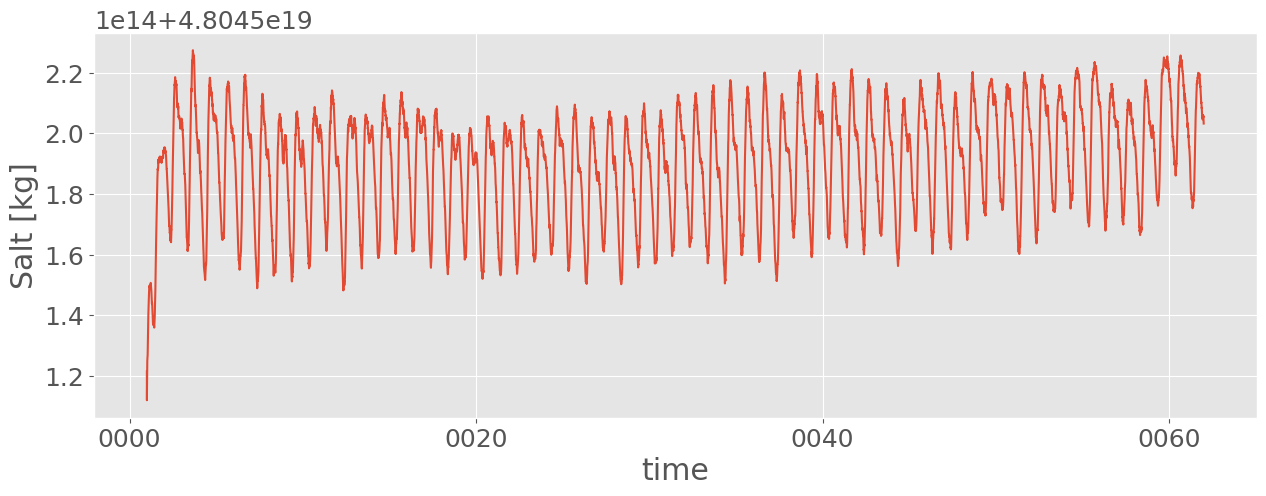

In [23]:
stats.Salt.plot(); 

### Total Salt Change between Entries

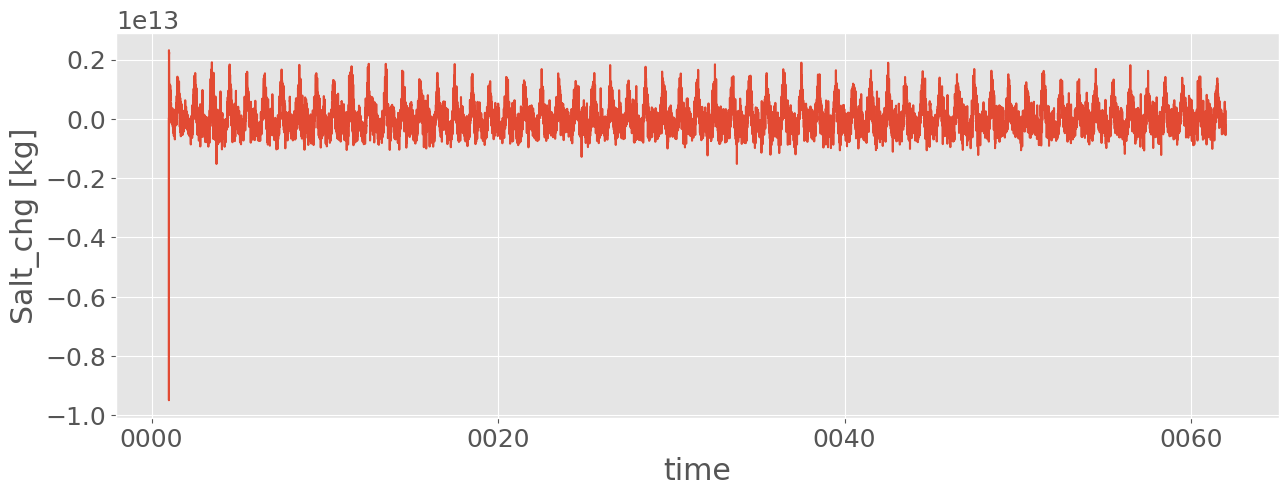

In [24]:
stats.Salt_chg.plot(); 

### Anomalous Total Salt Change

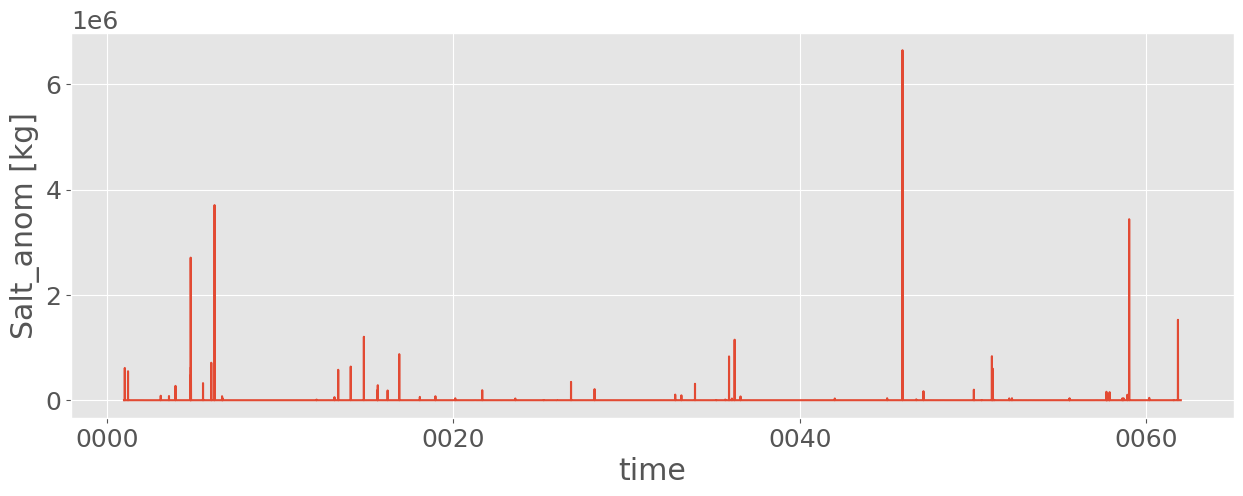

In [25]:
stats.Salt_anom.plot(); 

### Total Heat

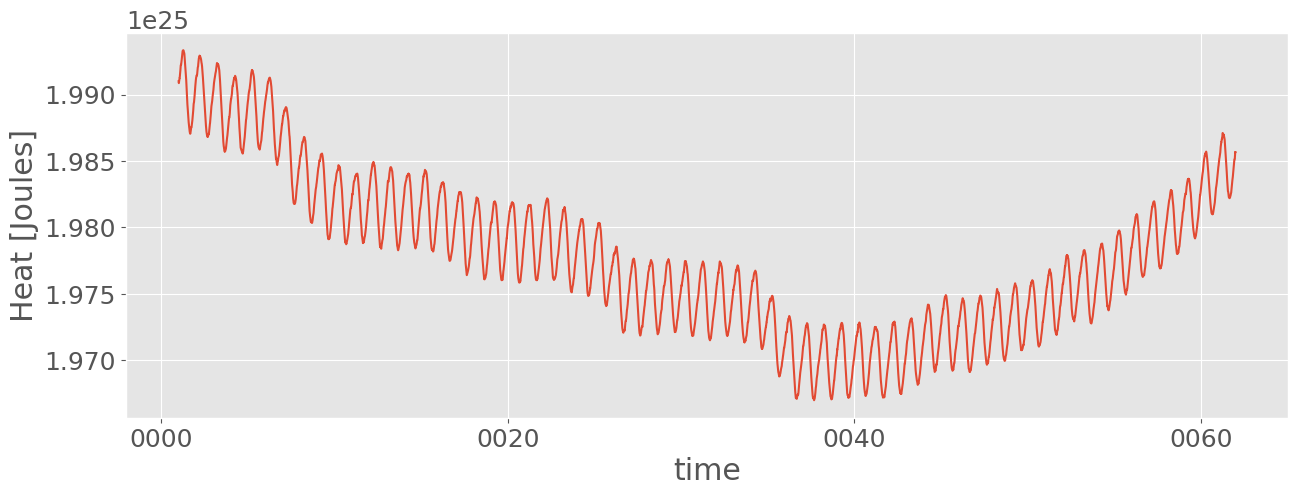

In [26]:
stats.Heat.plot(); 

### Total Heat Change between Entries

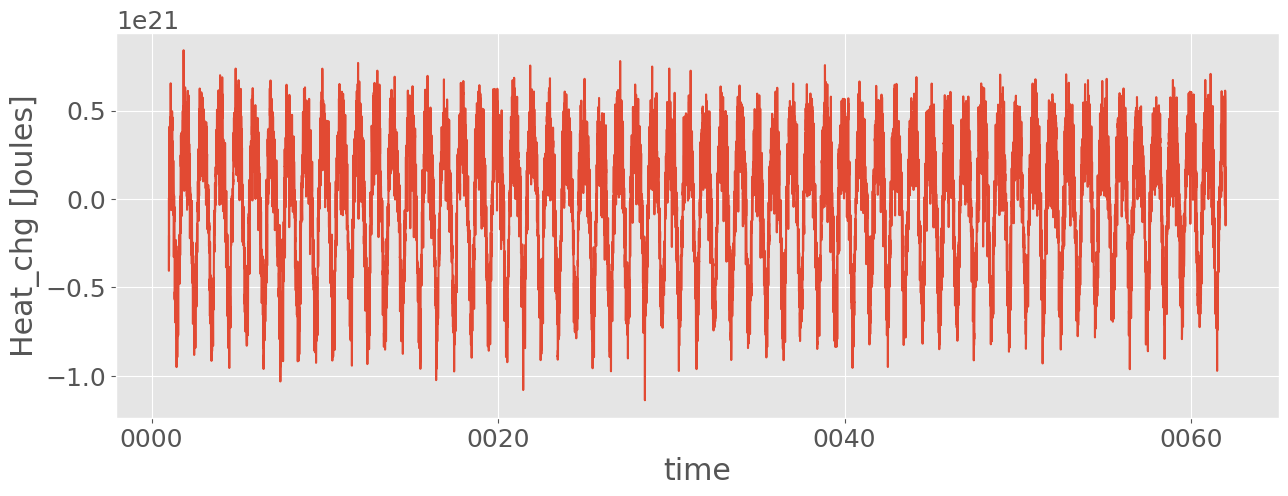

In [27]:
stats.Heat_chg.plot(); 

### Anomalous Total Heat Change

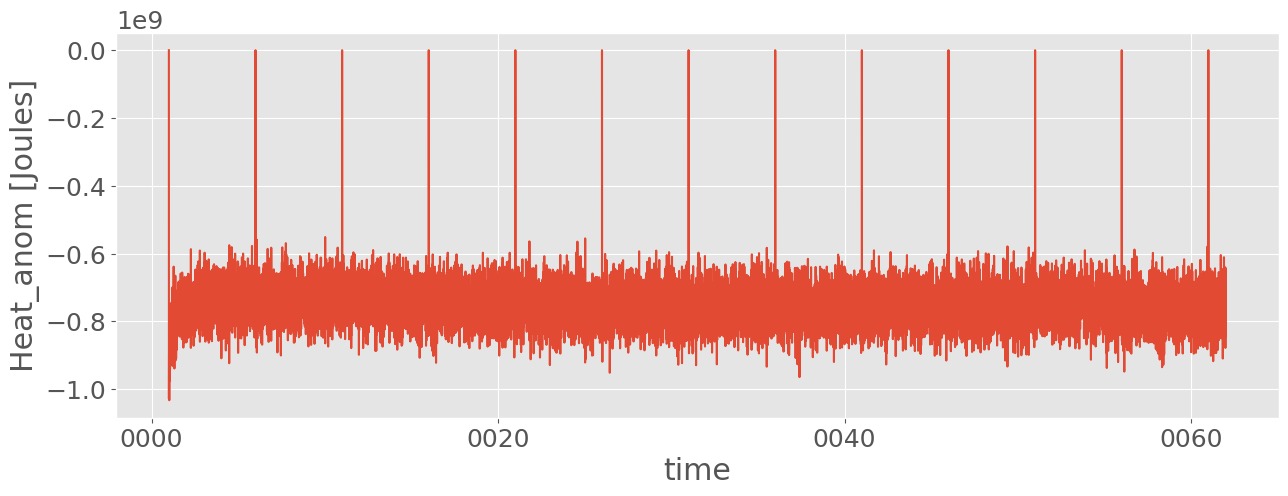

In [28]:
stats.Heat_anom.plot(); 

### Age

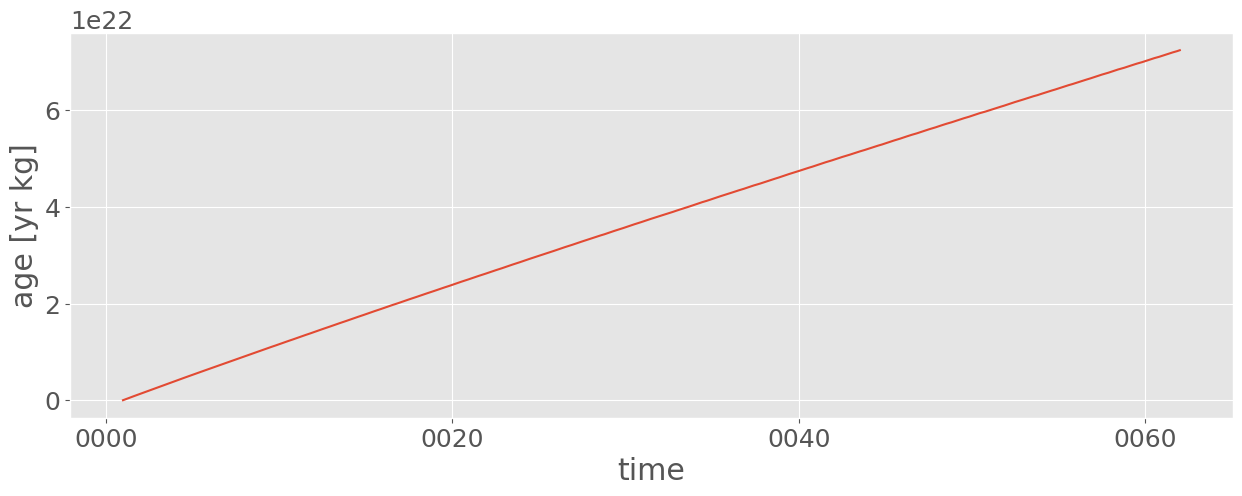

In [29]:
stats.age.plot(); 